# A QUICK NOTE ON THE STATS I HAVE COLLECTED

The purpose of this final go-round of data collection is simple: The greatest challenge of this project has been in feature selection and feature extraction. I have gone through COUNTLESS iterations of feature sets trying to answer the question: "What matters? What data tells the story that I need told?" There is such a wealth of baseball information that sifting through and trying to discover what are strong predictors of performance is not easy by any means. Additionally, many statistics are highly collinear and thus collinearity and multicollinearity have been major problems. However, when I have tried removing features, my results suffer from the information loss. So the challenge is, as it is in many data science projects, how can I tell the most story with the least information? That is what I am hoping these advanced metrics will do. I am particularly excited about wRC+. This is a RELATIVE statistic that is 100-based and weighted to reflect ballpark and league average factors. I am hoping that this statistic will allow me to compare teams from different eras as well as drop many of the collinear features without suffering the information loss. 

If you go and compare my wRC+ to the wRC+ on Fangraphs or Baseball-Reference, you will notice they are different. I will explain why. wRC+ is calculated to adjust for the ballpark that each team plays in. Each value is adjusted to accomodate for a factor unique to each ball park - it is much easier to hit in Coors Field in Colorado than it is to hit in Oracle Park in San Francisco for example. Fangraphs multiplies the entire season's stats by half of the stadium multiplier for each stadium. When I initially collected my data, that is what I did as well. However, I realized that this was a fallacy on my part. As I am collecting data at each game of the season, I need each team's wRC+ at each point in time in the season. Multiplying by the same park factor assumes that 50% of games have been played at the park. While that is true for each team at the end of the season, it is not true DURING the season. For example, a team may play their first 15 games on the road. Why then would I multiply by a park factor for a park they haven't even played at yet? Therefore, I actually calculated my wRC+ using the mean value of all park factors a team had played at that season. That way, it was an honest reflection of the parks that each team had played at. So I don't want to say that my stats are more accurate than FanGraphs, but my stats are more accurate than FanGraphs.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
import sys
sys.path.append("/Users/atticussoane/Desktop/atticus_tools")
from data_science import PrepTools, ModelSelectionTools
import os

In [27]:
pd.set_option("max.columns", 200)

working_df = pd.read_csv("./all_features.csv.gz", compression = "gzip")

working_df.head()

,date,is_doubleheader,is_tripleheader,home_OBPS,home_AVG_RUNS,home_AVG_H,home_BULLPEN_ERA,home_BULLPEN_WHIP,home_BULLPEN_AVG_INNINGS,home_total_OBPS,home_total_AVG_RUNS,home_total_AVG_H,home_total_BULLPEN_ERA,home_total_BULLPEN_WHIP,home_total_BULLPEN_AVG_INNINGS,road_OBPS,road_AVG_RUNS,road_AVG_H,road_BULLPEN_ERA,road_BULLPEN_WHIP,road_BULLPEN_AVG_INNINGS,road_total_OBPS,road_total_AVG_RUNS,road_total_AVG_H,road_total_BULLPEN_ERA,road_total_BULLPEN_WHIP,road_total_BULLPEN_AVG_INNINGS,home_starter,home_career_ERA,home_career_WHIP,home_career_AVGIP,home_career_ERA_AH,home_career_WHIP_AH,home_career_AVGIP_AH,home_season_ERA,home_season_WHIP,home_season_AVGIP,home_season_ERA_AH,home_season_WHIP_AH,home_season_AVGIP_AH,road_starter,road_career_ERA,road_career_WHIP,road_career_AVGIP,road_career_ERA_OR,road_career_WHIP_OR,road_career_AVGIP_OR,road_season_ERA,road_season_WHIP,road_season_AVGIP,road_season_ERA_OR,road_season_WHIP_OR,road_season_AVGIP_OR,team1,team2,home_loss,elo1_pre,elo2_pre,elo_prob1,elo_prob2,rating1_pre,rating2_pre,pitcher1_rgs,pitcher2_rgs,pitcher1_adj,pitcher2_adj,rating_prob1,rating_prob2,score1,score2,pitching_park_factor,batting_park_factor,TMAX,PRCP,SNOW,SNWD,attendance,current_streak_hm_tm,current_streak_hm_at_hm,home_record_hm,run_differential_hm,avg_margin_hm,distance_traveled,current_streak_rd_tm,current_streak_rd_tm_on_rd,rd_record_rd,run_differential_rd,avg_margin_rd,roof_closed,is_retractable,is_wildcard,is_divisional,is_championship,is_world_series,is_daygame,is_march,is_april,is_may,is_june,is_july,is_august,is_september,is_october,is_november
0,1918-04-15,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,ruthb101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,myere101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BOS,OAK,0,1532.718,1454.138,0.643479,0.356521,1532.879,1450.425,58.694,42.578,0.123919,7.593298,0.641039,0.358961,7.0,1.0,97.0,99.0,200.0,0.0,0.0,0.0,7000.0,0.0,0.0,0.0,0.0,0.0,429.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1918-04-15,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,johnw102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,mogrg101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,MIN,NYY,1,1506.347,1489.014,0.559204,0.440796,1505.980,1490.018,59.276,47.036,5.280727,12.779345,0.546438,0.453562,3.0,6.0,98.0,98.0,222.0,0.0,0.0,0.0,2461.0,0.0,0.0,0.0,0.0,0.0,338.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1918-04-16,0,0,0.696944,7.0,9.0,0.0,0.0,0.0,0.696944,7.0,9.0,0.0,0.0,0.0,0.315152,1.0,4.0,0.0,1.5,2.0,0.315152,1.0,4.0,0.0,1.5,2.0,maysc101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,perrs101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,BOS,OAK,0,1534.862,1451.995,0.649121,0.350879,1534.475,1448.829,57.569,46.170,0.123919,7.593298,0.642947,0.357053,1.0,0.0,97.0,99.0,172.0,0.0,0.0,0.0,2145.0,1.0,1.0,1.0,6.0,6.0,429.0,-1.0,-1.0,-1.0,-6.0,-6.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1918-04-16,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,mayee101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,ragap101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,PHI,ATL,0,1531.086,1511.721,0.562085,0.437915,1532.047,1510.253,47.964,50.186,5.197198,8.713313,0.566415,0.433585,5.0,2.0,108.0,107.0,161.0,0.0,0.0,0.0,10000.0,0.0,0.0,0.0,0.0,0.0,428.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1918-04-16,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,cicoe101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,lowdg101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,CHW,BAL,1,1557.404,1464.028,0.662772,0.337228,1557.576,1465.255,59.669,46.649,-3.174204,13

In [28]:
keep = ["date", "is_doubleheader", "home_starter", "road_starter", "elo1_pre", 
        "elo2_pre", "rating1_pre", "rating2_pre", "pitcher1_rgs", "pitcher2_rgs",
       "pitcher1_adj", "pitcher2_adj", "rating_prob1", "score1", "score2"]

working_df = working_df[keep]

In [4]:
df = pd.read_csv("./adv_metrics/compiled_unstable.csv.gz", compression = "gzip")

df.head()

,date,is_doubleheader,is_tripleheader,season,home_team,road_team,home_starter,road_starter,home_wOBA,home_wRAA,home_wRC,home_OPS,home_relief_wOBA,home_relief_wRAA,home_relief_wRC,home_relief_FIP,home_relief_WHIP,home_relief_ERA,home_relief_K_BB,home_relief_K_9,home_starter_career_wOBA,home_starter_career_wRAA,home_starter_career_wRC,home_starter_career_FIP,home_starter_career_WHIP,home_starter_career_ERA,home_starter_careerK/BB,home_starter_careerK/9,home_starter_career_AVGIP,home_starter_season_wOBA,home_starter_season_wRAA,home_starter_season_wRC,home_starter_season_FIP,home_starter_season_WHIP,home_starter_season_ERA,home_starter_seasonK/BB,home_starter_seasonK/9,home_starter_seasonAVG_IP,road_wOBA,road_wRAA,road_wRC,road_OPS,road_relief_wOBA,road_relief_wRAA,road_relief_wRC,road_relief_FIP,road_relief_WHIP,road_relief_ERA,road_relief_K_BB,road_relief_K_9,road_starter_career_wOBA,road_starter_career_wRAA,road_starter_career_wRC,road_starter_career_FIP,road_starter_career_WHIP,road_starter_career_ERA,road_starter_careerK/BB,road_starter_careerK/9,road_starter_career_AVGIP,road_starter_season_wOBA,road_starter_season_wRAA,road_starter_season_wRC,road_starter_season_FIP,road_starter_season_WHIP,road_starter_season_ERA,road_starter_seasonK/BB,road_starter_seasonK/9,road_starter_seasonAVG_IP
0,1918-04-15,0.0,0.0,1918,MIN,NYY,johnw102,mogrg101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1918-04-15,0.0,0.0,1918,BOS,OAK,ruthb101,myere101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1918-04-16,0.0,0.0,1918,PHI,ATL,mayee101,ragap101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1918-04-16,0.0,0.0,1918,CIN,PIT,schnp101,coopw101,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1918-04-16,0.0,0.0,1918,STL,CHC,meadl101,alexg102,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [5]:
for col in df.columns:
    
    if len(df[df[col].isnull()]) != 0:
        
        print(col)

home_relief_wOBA
home_relief_wRAA
home_relief_wRC
road_relief_wOBA
road_relief_wRAA
road_relief_wRC


In [6]:
df[(df.home_relief_wOBA.isnull()) | (df.road_relief_wOBA.isnull())]

,date,is_doubleheader,is_tripleheader,season,home_team,road_team,home_starter,road_starter,home_wOBA,home_wRAA,home_wRC,home_OPS,home_relief_wOBA,home_relief_wRAA,home_relief_wRC,home_relief_FIP,home_relief_WHIP,home_relief_ERA,home_relief_K_BB,home_relief_K_9,home_starter_career_wOBA,home_starter_career_wRAA,home_starter_career_wRC,home_starter_career_FIP,home_starter_career_WHIP,home_starter_career_ERA,home_starter_careerK/BB,home_starter_careerK/9,home_starter_career_AVGIP,home_starter_season_wOBA,home_starter_season_wRAA,home_starter_season_wRC,home_starter_season_FIP,home_starter_season_WHIP,home_starter_season_ERA,home_starter_seasonK/BB,home_starter_seasonK/9,home_starter_seasonAVG_IP,road_wOBA,road_wRAA,road_wRC,road_OPS,road_relief_wOBA,road_relief_wRAA,road_relief_wRC,road_relief_FIP,road_relief_WHIP,road_relief_ERA,road_relief_K_BB,road_relief_K_9,road_starter_career_wOBA,road_starter_career_wRAA,road_starter_career_wRC,road_starter_career_FIP,road_starter_career_WHIP,road_starter_career_ERA,road_starter_careerK/BB,road_starter_careerK/9,road_starter_career_AVGIP,road_starter_season_wOBA,road_starter_season_wRAA,road_starter_season_wRC,road_starter_season_FIP,road_starter_season_WHIP,road_starter_season_ERA,road_starter_seasonK/BB,road_starter_seasonK/9,road_starter_seasonAVG_IP
20120,1938-04-20,0.0,0.0,1938,STL,PIT,johns103,tobij103,0.340146,-0.094891,96.482664,0.736200,NaN,NaN,NaN,2.924,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.381119,1.329375,123.795453,0.825397,0.228111,-1.677210,21.798933,0.152637,0.923788,0.0,6.0,12.471132,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
39671,1956-04-20,0.0,0.0,1956,PHI,SFG,wehmh101,hearj102,0.294687,-2.085845,67.349187,0.645840,NaN,NaN,NaN,8.369,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.267821,-3.183472,59.251959,0.603416,0.323800,-0.017446,96.287291,1.369000,2.000000,4.5,2.0,18.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
64329,1972-04-16,0.0,0.0,1972,ANA,TEX,wrigc102,brobp101,0.198433,-2.319324,29.022247,0.425641,0.0,0.0,0.0,0.000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.165500,-3.141035,5.714624,0.295673,NaN,NaN,NaN,2.399000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Three games out of 170,000 - Not worth the time to determine the reason... dropping the observations.

In [7]:
df = df.dropna(how = "any")

In [8]:
df.date = pd.to_datetime(df.date, format = "%Y-%m-%d")

# SINGLE SEASON ANALYSIS

Just to ensure the metrics I have collected are good indicators of performance, I am going to look at the $2019$ season (which will eventually be used as my test data) and look into the distributions of my predictor metrics for that season. 

In [9]:
all_2019 = df[df.season == 2019].reset_index(drop = True)

In [10]:
all_2019.head()

,date,is_doubleheader,is_tripleheader,season,home_team,road_team,home_starter,road_starter,home_wOBA,home_wRAA,home_wRC,home_OPS,home_relief_wOBA,home_relief_wRAA,home_relief_wRC,home_relief_FIP,home_relief_WHIP,home_relief_ERA,home_relief_K_BB,home_relief_K_9,home_starter_career_wOBA,home_starter_career_wRAA,home_starter_career_wRC,home_starter_career_FIP,home_starter_career_WHIP,home_starter_career_ERA,home_starter_careerK/BB,home_starter_careerK/9,home_starter_career_AVGIP,home_starter_season_wOBA,home_starter_season_wRAA,home_starter_season_wRC,home_starter_season_FIP,home_starter_season_WHIP,home_starter_season_ERA,home_starter_seasonK/BB,home_starter_seasonK/9,home_starter_seasonAVG_IP,road_wOBA,road_wRAA,road_wRC,road_OPS,road_relief_wOBA,road_relief_wRAA,road_relief_wRC,road_relief_FIP,road_relief_WHIP,road_relief_ERA,road_relief_K_BB,road_relief_K_9,road_starter_career_wOBA,road_starter_career_wRAA,road_starter_career_wRC,road_starter_career_FIP,road_starter_career_WHIP,road_starter_career_ERA,road_starter_careerK/BB,road_starter_careerK/9,road_starter_career_AVGIP,road_starter_season_wOBA,road_starter_season_wRAA,road_starter_season_wRC,road_starter_season_FIP,road_starter_season_WHIP,road_starter_season_ERA,road_starter_seasonK/BB,road_starter_seasonK/9,road_starter_seasonAVG_IP
0,2019-03-20,0.0,0.0,2019,OAK,SEA,fierm001,gonzm005,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-03-21,0.0,0.0,2019,OAK,SEA,estrm001,kikuy001,0.372395,1.72083,138.824242,0.915789,0.30024,-0.426966,90.072455,5.547333,1.166667,6.0,1.75,10.5,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.345244,0.894555,120.479616,0.817467,0.322308,0.025929,104.982626,6.880667,1.333333,9.0,2.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-03-28,0.0,0.0,2019,CIN,PIT,castl003,tailj001,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-03-28,0.0,0.0,2019,PHI,ATL,nolaa001,tehej001,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-03-28,0.0,0.0,2019,WSN,NYM,schem001,degrj001,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 2019 ADVANCED OFFENSIVE METRICS

In [11]:
season_end_stats = []

for team in all_2019.home_team.unique():
    
    d = {}
    
    last_game_date = df[(df.home_team == team) |
                       (df.road_team == team)].date.max()
    
    if len(df[(df.date == last_game_date) & (df.home_team == team)]) != 0:
        
        loc = "home_"
        
    else:
        
        loc = "road_"
    
    d["team"] = team
    
    d["wOBA"] = df[(df.date == last_game_date) & (df[loc + "team"] == team)][loc + "wOBA"].values[0]
    
    d["wRAA"] = df[(df.date == last_game_date) & (df[loc + "team"] == team)][loc + "wRAA"].values[0]
    
    d["wRC"] = df[(df.date == last_game_date) & (df[loc + "team"] == team)][loc + "wRC"].values[0]
    
    d["OPS"] = df[(df.date == last_game_date) & (df[loc + "team"] == team)][loc + "OPS"].values[0]
    
    season_end_stats.append(d)

In [12]:
season_end2019 = pd.DataFrame(season_end_stats)

In [13]:
season_end2019.head()

,team,wOBA,wRAA,wRC,OPS
0,OAK,0.328895,47.933816,106.771988,0.778410
1,CIN,0.311335,-45.412462,88.682533,0.735257
2,PHI,0.314649,-28.761173,90.744745,0.745755
3,WSN,0.334522,78.172410,102.483519,0.794317
4,TBD,0.321334,7.206007,101.192210,0.757442


In [14]:
offensive_cols = ["wOBA", "wRAA", "wRC", "OPS"]

for col in offensive_cols:
    
    season_end2019[col] = (season_end2019[col] - season_end2019[col].mean()) / season_end2019[col].std()

In [15]:
if not os.path.exists("./adv_metrics/adv_metric_plots/"):
    os.makedirs("./adv_metrics/adv_metric_plots/")

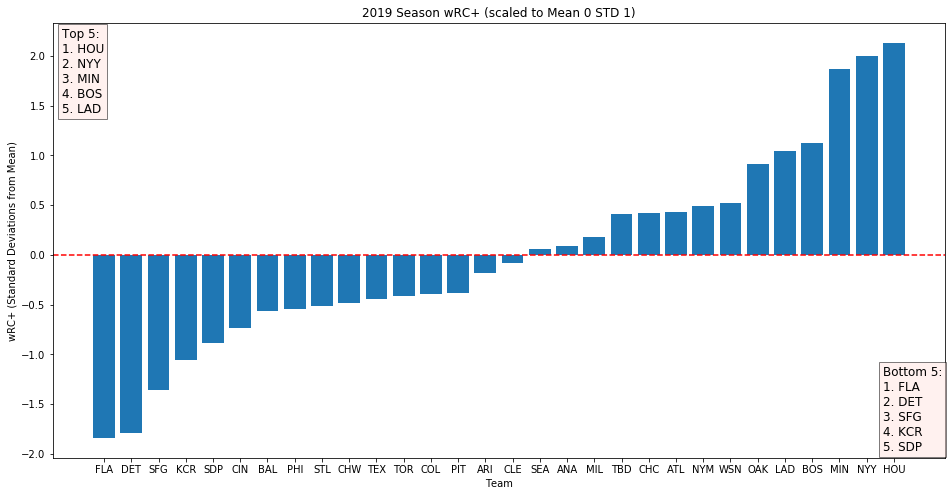

In [72]:
season_end2019 = season_end2019.sort_values(by = ["wRC"])

fig, ax = plt.subplots(figsize = (16, 8))

ax.bar(season_end2019.team, season_end2019.wRC)

ax.axhline(0.0, ls = "--", c = "r", xmin = 0., xmax = 1)

s = "Top 5:\n"
for i, team in enumerate(season_end2019.iloc[-1:-6:-1].team.values):
    s += "{}. {}\n".format(i+1 , team)
    
s2 = "Bottom 5:\n"
for i, team in enumerate(season_end2019.iloc[:5].team.values):
    s2 += "{}. {}\n".format(i+1, team)

text_box = {

    "boxstyle" : "square",

    "facecolor" : "mistyrose",

    "edgecolor" : "k",

    "alpha" : 0.5
}

ax.text(0.01, 0.99, s.strip(), transform = ax.transAxes, fontsize = 12, verticalalignment = "top",
        bbox = text_box)

ax.text(0.93, 0.01, s2.strip(), transform = ax.transAxes, fontsize = 12, verticalalignment = "bottom",
        bbox = text_box)

ax.set_title("2019 Season wRC+ (scaled to Mean 0 STD 1)")
             
ax.set_xlabel("Team")
             
ax.set_ylabel("wRC+ (Standard Deviations from Mean)");

plt.savefig("./adv_metrics/adv_metric_plots/2019wRC+")

# ADVANCED PITCHING METRICS

In [73]:
season_end_relief_stats = []

for team in all_2019.home_team.unique():
    
    d = {}
    
    last_game_date = df[(df.home_team == team) |
                       (df.road_team == team)].date.max()
    
    if len(df[(df.date == last_game_date) & (df.home_team == team)]) != 0:
        
        loc = "home_"
        
    else:
        
        loc = "road_"
    
    d["team"] = team
    
    d["wRC"] = df[(df.date == last_game_date) & (df[loc + "team"] == team)][loc + "relief_wRC"].values[0]
    
    season_end_relief_stats.append(d)

In [75]:
relief_df = pd.DataFrame(season_end_relief_stats)

relief_df["wRC"] = (relief_df["wRC"] - relief_df["wRC"].mean()) / relief_df["wRC"].std()

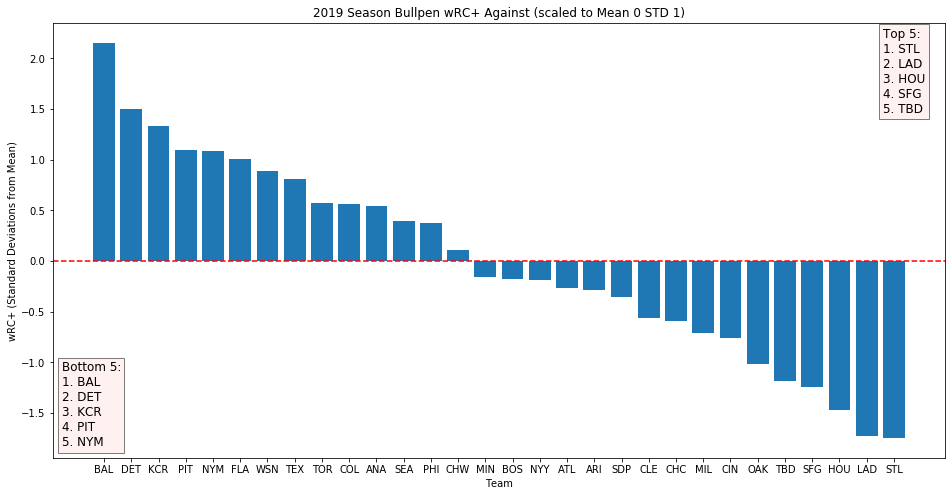

In [80]:
relief_df = relief_df.sort_values(by = ["wRC"], ascending = False)

fig, ax = plt.subplots(figsize = (16, 8))

ax.bar(relief_df.team, relief_df.wRC)

ax.axhline(0.0, ls = "--", c = "r", xmin = 0., xmax = 1)

s = "Top 5:\n"
for i, team in enumerate(relief_df.iloc[-1:-6:-1].team.values):
    s += "{}. {}\n".format(i+1 , team)
    
s2 = "Bottom 5:\n"
for i, team in enumerate(relief_df.iloc[:5].team.values):
    s2 += "{}. {}\n".format(i+1, team)

text_box = {

    "boxstyle" : "square",

    "facecolor" : "mistyrose",

    "edgecolor" : "k",

    "alpha" : 0.5
}

ax.text(0.01, 0.02, s2.strip(), transform = ax.transAxes, fontsize = 12, verticalalignment = "bottom",
        bbox = text_box)

ax.text(0.93, 0.99, s.strip(), transform = ax.transAxes, fontsize = 12, verticalalignment = "top",
        bbox = text_box)

ax.set_title("2019 Season Bullpen wRC+ Against (scaled to Mean 0 STD 1)")
             
ax.set_xlabel("Team")
             
ax.set_ylabel("wRC+ (Standard Deviations from Mean)");

plt.savefig("./adv_metrics/adv_metric_plots/2019BullpenwRC+")

In [17]:
betting_odds = pd.read_csv("./adv_metrics/all_odds2010.csv.gz", compression = "gzip")

betting_odds.head()

,date,home_close_TJ,home_close_ou,home_closing,home_open_TJ,home_open_ou,home_opening,home_runline,home_runline_juice,is_doubleheader,road_close_TJ,road_close_ou,road_closing,road_open_TJ,road_open_ou,road_opening,road_runline,road_runline_juice,team1,team2
0,2010-04-04,-115,9,-117.0,-104,9.0,-114,NaN,NaN,0,-105,9,107.0,-116,9.0,104,NaN,NaN,BOS,NYY
1,2010-04-05,105,7.5,175.0,-120,7.5,175,NaN,NaN,0,-125,7.5,-200.0,100,7.5,-200,NaN,NaN,WSN,PHI
2,2010-04-05,-105,7,137.0,-105,7.0,110,NaN,NaN,0,-115,7,-152.0,-115,7.0,-125,NaN,NaN,OAK,SEA
3,2010-04-05,110,8.5,-128.0,100,8.5,-135,NaN,NaN,0,-130,8.5,113.0,-120,8.5,120,NaN,NaN,ANA,MIN
4,2010-04-05,-115,7,-122.0,-115,7.0,-115,NaN,NaN,0,-105,7,112.0,-105,7.0,105,NaN,NaN,KCR,DET


In [18]:
betting_odds.date = pd.to_datetime(betting_odds.date, format = "%Y-%m-%d")

merge_cols_left = ["date", "is_doubleheader", "team1", "team2"]

merge_cols_right = ["date", "is_doubleheader", "home_team", "road_team"]

betting_odds = betting_odds.merge(df, how = "left", left_on = merge_cols_left,
                                 right_on = merge_cols_right)

betting_odds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24647 entries, 0 to 24646
Data columns (total 86 columns):
date                         24647 non-null datetime64[ns]
home_close_TJ                24647 non-null int64
home_close_ou                24647 non-null object
home_closing                 24647 non-null float64
home_open_TJ                 24647 non-null int64
home_open_ou                 24647 non-null float64
home_opening                 24647 non-null object
home_runline                 14782 non-null float64
home_runline_juice           14782 non-null float64
is_doubleheader              24647 non-null int64
road_close_TJ                24647 non-null int64
road_close_ou                24647 non-null object
road_closing                 24647 non-null float64
road_open_TJ                 24647 non-null int64
road_open_ou                 24647 non-null float64
road_opening                 24647 non-null object
road_runline                 14782 non-null float64
road_runline_j

In [20]:
betting_odds = betting_odds.dropna(axis = 0, thresh = 60)

betting_odds.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24284 entries, 0 to 24609
Data columns (total 86 columns):
date                         24284 non-null datetime64[ns]
home_close_TJ                24284 non-null int64
home_close_ou                24284 non-null object
home_closing                 24284 non-null float64
home_open_TJ                 24284 non-null int64
home_open_ou                 24284 non-null float64
home_opening                 24284 non-null object
home_runline                 14565 non-null float64
home_runline_juice           14565 non-null float64
is_doubleheader              24284 non-null int64
road_close_TJ                24284 non-null int64
road_close_ou                24284 non-null object
road_closing                 24284 non-null float64
road_open_TJ                 24284 non-null int64
road_open_ou                 24284 non-null float64
road_opening                 24284 non-null object
road_runline                 14565 non-null float64
road_runline_j

In [7]:
def calculate_totalpayout(df):
    ''' 
    Assuming $1.00 bet for simplicity
    '''
    home_outcome = []
    road_outcome = []
    for k in range(len(df)):
        if df.iloc[k]['home_closing'] < 0:
            home_outcome.append(-100.0 / df.iloc[k]['home_closing'] + 1)
        else:
            home_outcome.append(df.iloc[k]['home_closing'] / 100 + 1)
        if df.iloc[k]['road_closing'] < 0:
            road_outcome.append(-100.0 / df.iloc[k]['road_closing'] + 1)
        else:
            road_outcome.append(df.iloc[k]['road_closing'] / 100 + 1)
    return(pd.Series(home_outcome), pd.Series(road_outcome))

home_payout, road_payout = calculate_totalpayout(betting_odds)

In [8]:
betting_odds = pd.concat([betting_odds, home_payout, road_payout], axis = 1)

betting_odds = betting_odds.rename(columns = {0 : "home_payout",
                                             1 : "road_payout"})

In [9]:
betting_odds.head()

,date,home_close_TJ,home_close_ou,home_closing,home_open_TJ,home_open_ou,home_opening,home_runline,home_runline_juice,is_doubleheader,road_close_TJ,road_close_ou,road_closing,road_open_TJ,road_open_ou,road_opening,road_runline,road_runline_juice,team1,team2,is_tripleheader,season,home_team,road_team,home_starter,road_starter,home_wOBA,home_wRAA,home_wRC,home_OPS,home_relief_wOBA,home_relief_wRAA,home_relief_wRC,home_relief_FIP,home_relief_WHIP,home_relief_ERA,home_relief_K_BB,home_relief_K_9,home_starter_career_wOBA,home_starter_career_wRAA,home_starter_career_wRC,home_starter_career_FIP,home_starter_career_WHIP,home_starter_career_ERA,home_starter_careerK/BB,home_starter_careerK/9,home_starter_career_AVGIP,home_starter_season_wOBA,home_starter_season_wRAA,home_starter_season_wRC,home_starter_season_FIP,home_starter_season_WHIP,home_starter_season_ERA,home_starter_seasonK/BB,home_starter_seasonK/9,home_starter_seasonAVG_IP,road_wOBA,road_wRAA,road_wRC,road_OPS,road_relief_wOBA,road_relief_wRAA,road_relief_wRC,road_relief_FIP,road_relief_WHIP,road_relief_ERA,road_relief_K_BB,road_relief_K_9,road_starter_career_wOBA,road_starter_career_wRAA,road_starter_career_wRC,road_starter_career_FIP,road_starter_career_WHIP,road_starter_career_ERA,road_starter_careerK/BB,road_starter_careerK/9,road_starter_career_AVGIP,road_starter_season_wOBA,road_starter_season_wRAA,road_starter_season_wRC,road_starter_season_FIP,road_starter_season_WHIP,road_starter_season_ERA,road_starter_seasonK/BB,road_starter_seasonK/9,road_starter_seasonAVG_IP,0,1
0,2010-04-04,-115,9,-117.0,-104,9.0,-114,NaN,NaN,0,-105,9,107.0,-116,9.0,104,NaN,NaN,BOS,NYY,0.0,2010.0,BOS,NYY,beckj002,sabac001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.854701,2.070000
1,2010-04-05,105,7.5,175.0,-120,7.5,175,NaN,NaN,0,-125,7.5,-200.0,100,7.5,-200,NaN,NaN,WSN,PHI,0.0,2010.0,WSN,PHI,lannj001,hallr001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.750000,1.500000
2,2010-04-05,-105,7,137.0,-105,7.0,110,NaN,NaN,0,-115,7,-152.0,-115,7.0,-125,NaN,NaN,OAK,SEA,0.0,2010.0,OAK,SEA,sheeb001,hernf002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.370000,1.657895
3,2010-04-05,110,8.5,-128.0,100,8.5,-135,NaN,NaN,0,-130,8.5,113.0,-120,8.5,120,NaN,NaN,ANA,MIN,0.0,2010.0,ANA,MIN,weavj003,bakes002,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.781250,2.130000
4,2010-04-05,-115,7,-122.0,-115,7.0,-115,NaN,NaN,0,-105,7,112.0,-105,7.0,105,NaN,NaN,KCR,DET,0.0,2010.0,KCR,DET,greiz001,verlj001,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.819672,2.120000


In [34]:
betting_odds = betting_odds.drop(columns = ["team1", "team2"])

In [36]:
betting_odds.date = pd.to_datetime(betting_odds.date, format = "%Y-%m-%d")

In [33]:
working_df.date = pd.to_datetime(working_df.date, format = "%Y-%m-%d")

In [37]:
merge_cols = ["date", "is_doubleheader", "home_starter", "road_starter"]

betting_odds = betting_odds.merge(working_df, how = "left", left_on = merge_cols,
                                 right_on = merge_cols)

In [53]:
drop_indices = betting_odds[(betting_odds.score1.isnull()) | (betting_odds.score2.isnull())].index

len(drop_indices)

345

In [54]:
betting_odds = betting_odds.drop(drop_indices, axis = 0).reset_index(drop = True)

In [55]:
betting_odds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23939 entries, 0 to 23938
Data columns (total 97 columns):
date                         23939 non-null datetime64[ns]
home_close_TJ                23939 non-null int64
home_close_ou                23939 non-null object
home_closing                 23939 non-null float64
home_open_TJ                 23939 non-null int64
home_open_ou                 23939 non-null float64
home_opening                 23939 non-null object
home_runline                 14346 non-null float64
home_runline_juice           14346 non-null float64
is_doubleheader              23939 non-null int64
road_close_TJ                23939 non-null int64
road_close_ou                23939 non-null object
road_closing                 23939 non-null float64
road_open_TJ                 23939 non-null int64
road_open_ou                 23939 non-null float64
road_opening                 23939 non-null object
road_runline                 14346 non-null float64
road_runline_j

In [126]:
home_win = []

home_favorite = []

for k in range(len(betting_odds)):
    
    if betting_odds.iloc[k]["score1"] > betting_odds.iloc[k]["score2"]:
        
        home_win.append(1)
        
    else:
        
        home_win.append(0)
        
    if betting_odds.iloc[k]["home_closing"] < 0:
        
        home_favorite.append(1)
        
    else:
        
        home_favorite.append(0)
        
home_favorite = pd.Series(home_favorite).rename("home_favorite")
        
home_win = pd.Series(home_win).rename("home_win")



betting_odds = pd.concat([betting_odds, home_win, home_favorite], axis = 1)

In [127]:
betting_odds.to_csv("./adv_metrics/all_metrics_with_odds.csv.gz", index = False, compression = "gzip")

In [3]:
betting_odds = pd.read_csv("./adv_metrics/all_metrics_with_odds.csv.gz", compression = "gzip", low_memory = False)

In [4]:
betting_odds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23939 entries, 0 to 23938
Data columns (total 99 columns):
date                         23939 non-null object
home_close_TJ                23939 non-null int64
home_close_ou                23939 non-null object
home_closing                 23939 non-null float64
home_open_TJ                 23939 non-null int64
home_open_ou                 23939 non-null float64
home_opening                 23939 non-null object
home_runline                 14346 non-null float64
home_runline_juice           14346 non-null float64
is_doubleheader              23939 non-null int64
road_close_TJ                23939 non-null int64
road_close_ou                23939 non-null object
road_closing                 23939 non-null float64
road_open_TJ                 23939 non-null int64
road_open_ou                 23939 non-null float64
road_opening                 23939 non-null object
road_runline                 14346 non-null float64
road_runline_juice    

# DATA EXPLORATION

### INTERESTING NOTES ABOUT THE TARGET

In [119]:
x = betting_odds.home_favorite.unique()

height = betting_odds.home_favorite.value_counts().values

In [120]:
tick_labels = ["home_favorite", "home_underdog"]

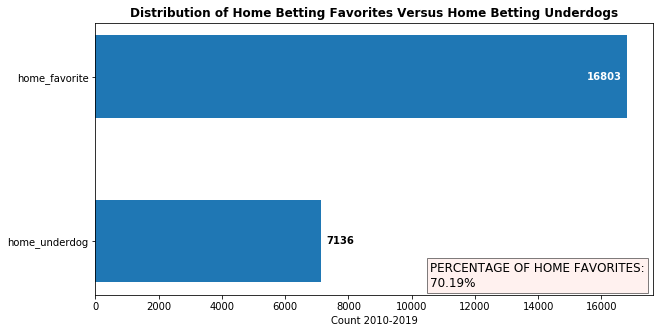

In [121]:
fig, ax1 = plt.subplots(figsize = (10, 5))

rects = ax1.barh(x, height,
                     align='center',
                     height=0.5,
                tick_label = tick_labels)

for rect in rects:
    width = rect.get_width()
    lbl = "{}".format(str(width))
    if width < 10000:
        xshift = 5
        c = "black"
        align = "left"
    else:
        xshift = -5
        c = "white"
        align = "right"

    yshift = rect.get_y() + rect.get_height() / 2

    label = ax1.annotate(lbl, xy=(width, yshift), xytext=(xshift, 0),
                        textcoords="offset points",
                        ha=align, va='center',
                        color=c, weight='bold', clip_on=True)

text_box = {

    "boxstyle" : "square",

    "facecolor" : "mistyrose",

    "edgecolor" : "k",

    "alpha" : 0.5
}

s = "PERCENTAGE OF HOME FAVORITES:\n{}%".format(round(height[0] / sum(height), 4) * 100)

ax1.text(0.6, 0.02, s, transform = ax1.transAxes, fontsize = 12, verticalalignment = "bottom",
        bbox = text_box)

ax1.set_xlabel("Count 2010-2019")

ax1.set_title("Distribution of Home Betting Favorites Versus Home Betting Underdogs", weight = "bold");

plt.savefig("./adv_metrics/adv_metric_plots/home_favorite_distribution")

In [131]:
x = betting_odds.home_win.unique()

height = betting_odds.home_win.value_counts().values

tick_labels = ["home_win", "home_loss"]

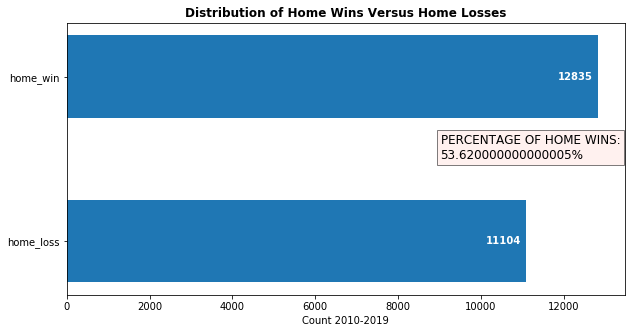

In [134]:
fig, ax1 = plt.subplots(figsize = (10, 5))

rects = ax1.barh(x, height,
                     align='center',
                     height=0.5,
                tick_label = tick_labels)

for rect in rects:
    width = rect.get_width()
    lbl = "{}".format(str(width))
    if width < 10000:
        xshift = 5
        c = "black"
        align = "left"
    else:
        xshift = -5
        c = "white"
        align = "right"

    yshift = rect.get_y() + rect.get_height() / 2

    label = ax1.annotate(lbl, xy=(width, yshift), xytext=(xshift, 0),
                        textcoords="offset points",
                        ha=align, va='center',
                        color=c, weight='bold', clip_on=True)

text_box = {

    "boxstyle" : "square",

    "facecolor" : "mistyrose",

    "edgecolor" : "k",

    "alpha" : 0.5
}

s = "PERCENTAGE OF HOME WINS:\n{}%".format(round(height[0] / sum(height), 4) * 100)

ax1.text(0.67, 0.5, s, transform = ax1.transAxes, fontsize = 12,
        bbox = text_box)

ax1.set_xlabel("Count 2010-2019")

ax1.set_title("Distribution of Home Wins Versus Home Losses", weight = "bold");

plt.savefig("./adv_metrics/adv_metric_plots/home_win_distribution")

These two plots show something extremely noteworthy: While the home team is favored in $70\%$ of matchups, they only win $53\%$. It is discrepancies like this we will need to harness.

In [137]:
home_dogs = betting_odds[betting_odds.home_closing > 0]

x = home_dogs.home_win.unique()

height = home_dogs.home_win.value_counts().values

tick_labels = ["home_loss", "home_win"]

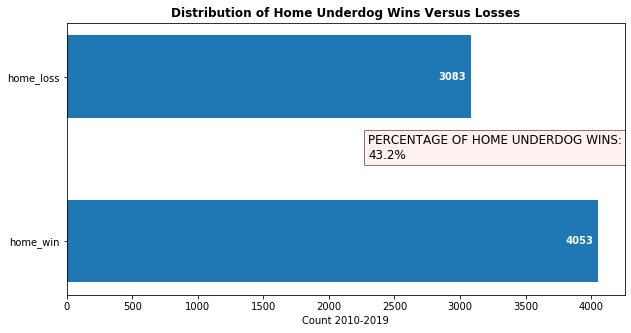

In [144]:
fig, ax1 = plt.subplots(figsize = (10, 5))

rects = ax1.barh(x, height,
                     align='center',
                     height=0.5,
                tick_label = tick_labels)

for rect in rects:
    width = rect.get_width()
    lbl = "{}".format(str(width))
    if width < 3000:
        xshift = 5
        c = "black"
        align = "left"
    else:
        xshift = -5
        c = "white"
        align = "right"

    yshift = rect.get_y() + rect.get_height() / 2

    label = ax1.annotate(lbl, xy=(width, yshift), xytext=(xshift, 0),
                        textcoords="offset points",
                        ha=align, va='center',
                        color=c, weight='bold', clip_on=True)

text_box = {

    "boxstyle" : "square",

    "facecolor" : "mistyrose",

    "edgecolor" : "k",

    "alpha" : 0.5
}

s = "PERCENTAGE OF HOME UNDERDOG WINS:\n{}%".format(round(height[1] / sum(height), 4) * 100)

ax1.text(0.54, 0.5, s, transform = ax1.transAxes, fontsize = 12,
        bbox = text_box)

ax1.set_xlabel("Count 2010-2019")

ax1.set_title("Distribution of Home Underdog Wins Versus Losses", weight = "bold");

plt.savefig("./adv_metrics/adv_metric_plots/home_dogs_distribution")

ANOTHER INTERESTING NOTE! Home underdogs win $43\%$ of their games.

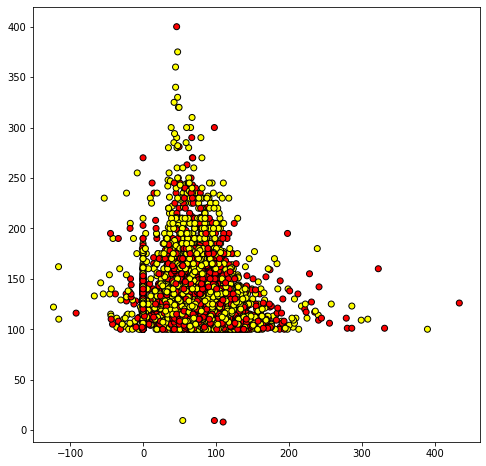

In [154]:
color_scheme = np.where(home_dogs.home_win == 1, "red", "yellow")

x = home_dogs.home_closing.values

y = home_dogs.road_starter_season_wRC.values

fig, ax = plt.subplots(figsize = (8, 8))

ax.scatter(y, x, c = color_scheme, edgecolors = "black");

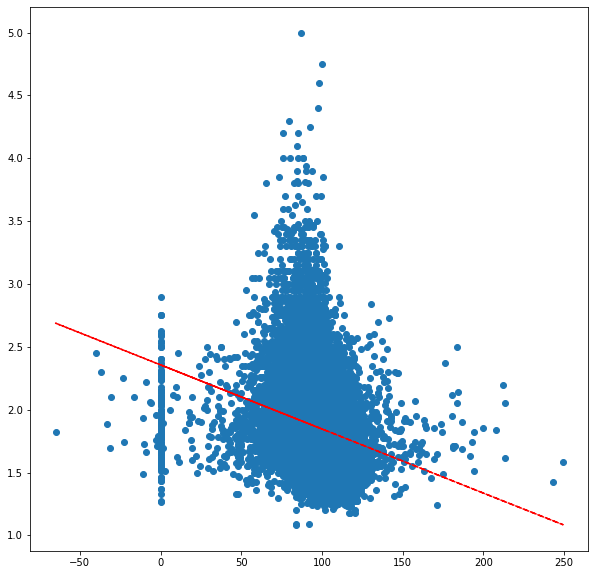

In [26]:
fig, ax = plt.subplots(figsize = (10, 10))

z = np.polyfit(betting_odds.home_wRC, betting_odds.home_payout, 1)

p = np.poly1d(z)

ax.scatter(betting_odds.home_wRC, betting_odds.home_payout)

ax.plot(betting_odds.home_wRC, p(betting_odds.home_wRC), ls = "--", c = "r")